In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Dict, Tuple, List, Optional

In [3]:
class RealisticCompositeAnalysis:
    def __init__(self, 
                 mean_strength: float = 1000,
                 std_dev: float = 50,
                 num_batches: int = 5,
                 samples_per_batch: int = 6):
        """
        Initialize with more realistic composite material variation factors
        
        Parameters:
        -----------
        mean_strength: float
            Base mean strength
        std_dev: float
            Base standard deviation
        num_batches: int
            Number of batches
        samples_per_batch: int
            Samples per batch
        """
        self.mean_strength = mean_strength
        self.std_dev = std_dev
        self.num_batches = num_batches
        self.samples_per_batch = samples_per_batch
        
        # Knockdown factors
        self.knockdown_factors = {
            'material_variability': 0.95,  # Material variability factor
            'safety_factor': 0.85,         # Safety factor
            'environmental': 0.90,         # Environmental effects
            'manufacturing': 0.92          # Manufacturing variability
        }
        
        # Batch effect parameters
        self.batch_effects = {
            'raw_material_variation': 0.03,    # Coefficient of variation for raw material
            'supplier_variation': 0.04,        # Additional variation from supplier changes
            'process_drift_rate': 0.01         # Rate of drift per batch
        }
        
        # Distribution shape parameters
        self.distribution_params = {
            'skewness': -0.5,              # Negative skew (typical for composites)
            'outlier_probability': 0.05,    # 5% chance of outliers
            'outlier_severity': 2.0         # How many std devs away outliers typically are
        }
    
    def apply_knockdown_factors(self, strength_value: float) -> float:
        """Apply all knockdown factors to a strength value"""
        total_knockdown = np.prod(list(self.knockdown_factors.values()))
        return strength_value * total_knockdown
    
    def generate_batch_parameters(self) -> List[Dict]:
        """Generate realistic batch parameters including supplier and process drift effects"""
        batch_params = []
        current_drift = 0
        
        for batch in range(self.num_batches):
            # Simulate supplier changes (random steps in material properties)
            supplier_effect = np.random.normal(1.0, self.batch_effects['supplier_variation'])
            
            # Simulate process drift over time
            current_drift -= self.batch_effects['process_drift_rate']
            
            # Simulate raw material variation
            raw_material_effect = np.random.normal(1.0, self.batch_effects['raw_material_variation'])
            
            batch_params.append({
                'batch_id': batch,
                'supplier_effect': supplier_effect,
                'process_drift': current_drift,
                'raw_material_effect': raw_material_effect
            })
        
        return batch_params
    
    def generate_skewed_distribution(self, size: int, mean: float, std: float) -> np.ndarray:
        """Generate skewed distribution using skew-normal distribution"""
        return stats.skewnorm.rvs(
            a=self.distribution_params['skewness'],
            loc=mean,
            scale=std,
            size=size
        )
    
    def add_outliers(self, data: np.ndarray) -> np.ndarray:
        """Add realistic outliers to the dataset"""
        n_outliers = int(len(data) * self.distribution_params['outlier_probability'])
        outlier_indices = np.random.choice(len(data), n_outliers, replace=False)
        
        for idx in outlier_indices:
            # Randomly decide if outlier is high or low
            direction = np.random.choice([-1, 1])
            severity = np.random.normal(self.distribution_params['outlier_severity'], 0.5)
            data[idx] = np.mean(data) + direction * severity * np.std(data)
        
        return data
    
    def generate_realistic_data(self) -> Tuple[np.ndarray, pd.DataFrame]:
        """
        Generate realistic composite material test data with batch effects,
        knockdowns, and non-normal distributions
        
        Returns:
        --------
        Tuple[np.ndarray, pd.DataFrame]:
            - Array of all strength values
            - DataFrame with detailed batch information
        """
        batch_params = self.generate_batch_parameters()
        all_data = []
        batch_data = []
        
        for batch_param in batch_params:
            # Calculate effective mean and std for this batch
            batch_mean = self.mean_strength * (
                1 + batch_param['supplier_effect'] +
                batch_param['process_drift'] +
                batch_param['raw_material_effect']
            )
            
            # Generate skewed distribution for batch
            batch_strength = self.generate_skewed_distribution(
                self.samples_per_batch,
                batch_mean,
                self.std_dev
            )
            
            # Add outliers
            batch_strength = self.add_outliers(batch_strength)
            
            # Apply knockdown factors
            batch_strength = np.array([self.apply_knockdown_factors(s) for s in batch_strength])
            
            all_data.extend(batch_strength)
            
            # Store batch information
            for strength in batch_strength:
                batch_data.append({
                    'batch_id': batch_param['batch_id'],
                    'strength': strength,
                    'supplier_effect': batch_param['supplier_effect'],
                    'process_drift': batch_param['process_drift'],
                    'raw_material_effect': batch_param['raw_material_effect']
                })
        
        return np.array(all_data), pd.DataFrame(batch_data)
    
    def analyze_data(self, data: np.ndarray, batch_info: pd.DataFrame) -> Dict:
        """Perform comprehensive analysis of the generated data"""
        analysis = {
            'mean': np.mean(data),
            'std': np.std(data),
            'skewness': stats.skew(data),
            'kurtosis': stats.kurtosis(data),
            'cv': np.std(data) / np.mean(data),
            'batch_effects': {
                'between_batch_var': np.var(batch_info.groupby('batch_id')['strength'].mean()),
                'within_batch_var': np.mean(batch_info.groupby('batch_id')['strength'].var()),
                'process_drift_effect': np.corrcoef(
                    batch_info['batch_id'],
                    batch_info['strength']
                )[0,1]
            }
        }
        return analysis

    def plot_comprehensive_analysis(self, data: np.ndarray, batch_info: pd.DataFrame):
        """Create comprehensive visualization of the realistic data"""
        plt.style.use('seaborn-v0_8-pastel')
        fig = plt.figure(figsize=(15, 10))
        gs = plt.GridSpec(2, 2)
        
        # 1. Distribution with skewness
        ax1 = fig.add_subplot(gs[0, 0])
        sns.histplot(data, kde=True, ax=ax1)
        ax1.set_title(f'Strength Distribution\nSkewness: {stats.skew(data):.3f}')
        ax1.grid(True)
        
        # 2. Batch effects
        ax2 = fig.add_subplot(gs[0, 1])
        sns.boxplot(x='batch_id', y='strength', data=batch_info, ax=ax2)
        ax2.set_title('Batch-to-Batch Variation')
        ax2.grid(True)
        
        # 3. Process drift visualization
        ax3 = fig.add_subplot(gs[1, 0])
        sns.regplot(x='batch_id', y='strength', data=batch_info, ax=ax3)
        ax3.set_title('Process Drift Over Time')
        ax3.grid(True)
        
        # 4. QQ plot for non-normality assessment
        ax4 = fig.add_subplot(gs[1, 1])
        stats.probplot(data, dist="norm", plot=ax4)
        ax4.set_title('Q-Q Plot')
        ax4.grid(True)
        
        plt.tight_layout()
        return fig


Analysis Results:
Mean Strength: 1977.9
Std Dev: 36.6
Coefficient of Variation: 0.018
Skewness: -0.119

Batch Effects:
Between-batch variance: 516.2
Within-batch variance: 984.7
Process drift correlation: -0.047


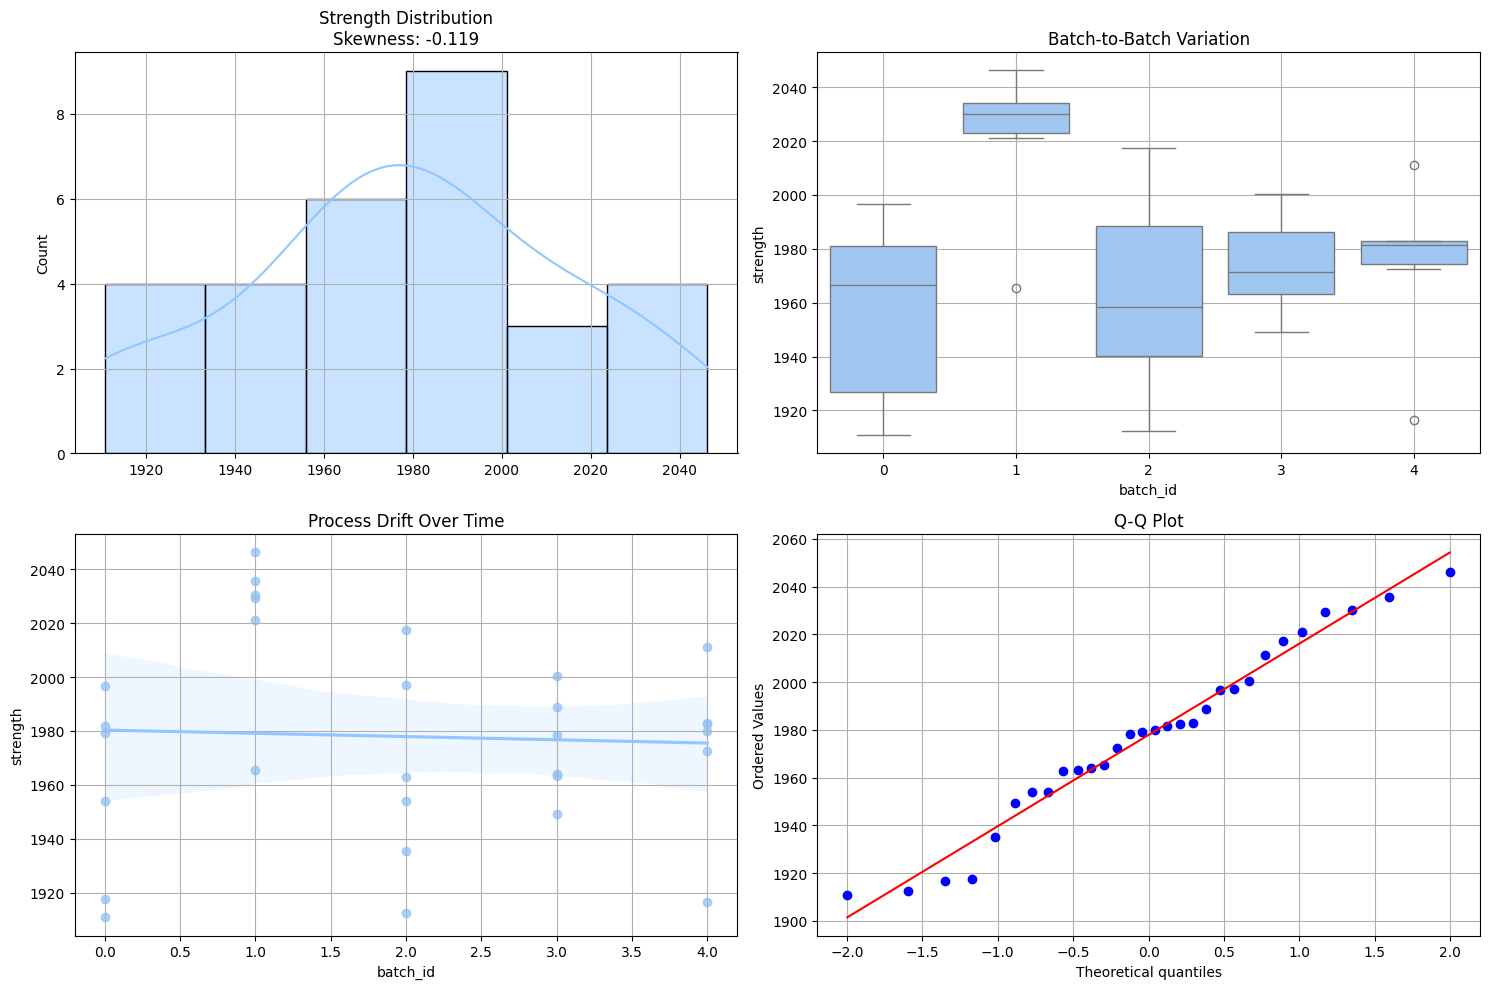

In [4]:

analysis = RealisticCompositeAnalysis(
    mean_strength=1000,
    std_dev=50,
    num_batches=5,
    samples_per_batch=6
)

# Generate and analyze data
data, batch_info = analysis.generate_realistic_data()
results = analysis.analyze_data(data, batch_info)

# Print analysis results
print("\nAnalysis Results:")
print(f"Mean Strength: {results['mean']:.1f}")
print(f"Std Dev: {results['std']:.1f}")
print(f"Coefficient of Variation: {results['cv']:.3f}")
print(f"Skewness: {results['skewness']:.3f}")
print("\nBatch Effects:")
print(f"Between-batch variance: {results['batch_effects']['between_batch_var']:.1f}")
print(f"Within-batch variance: {results['batch_effects']['within_batch_var']:.1f}")
print(f"Process drift correlation: {results['batch_effects']['process_drift_effect']:.3f}")

# Create visualization
analysis.plot_comprehensive_analysis(data, batch_info)
plt.show()